In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [3]:
import random
class playerQ(object):
    def __init__(self,alpha = 0.9 , gamma = 0.9 , e_value = 1, e_decay = 0.01,a_values= []):
        self.alpha = alpha
        self.gamma = gamma
        self.e_value = e_value
        self.e_decay = e_decay
        self.rng = np.random.default_rng() 
        self.a_values = a_values
    def set_q_table(self, rows, cols):
        self.q_table = np.zeros((int(rows), int(cols)))
    def decay(self):
        self.e_value = max(self.e_value -  self.e_decay, 0) #decay randomenes of transitions
        if(self.e_value==0):
            self.alpha = 0.0001
    def fit_table(self,state,a,reward,next): #fits q values of transition states (s,a,s') = q_value
        self.q_table[state,a] = self.q_table[state,a] + self.alpha * (
                    reward + self.gamma * np.max(self.q_table[next,:]) - self.q_table[state,a]
                )  
    def get_next(self,state): #returns the transition basen on the max reward given the current state
        if self.rng.random() < self.e_value: 
            return random.choice(self.a_values)
        else:
            return int(np.argmax(self.q_table[state,:]))


In [16]:

def run(rend=False,steps=1000,e_value= 1, e_decay = 0.01,random_map = True):
    rewards = np.zeros(steps)
    qlearner =playerQ(a_values=[0,1,2,3], e_value=e_value, e_decay=e_decay)
    if random_map: 
        env = gym.make('FrozenLake-v1',desc=generate_random_map(size=4), is_slippery=True, render_mode='human' if rend else None)
    else:
        env = gym.make('FrozenLake-v1',map_name="4x4", is_slippery=True, render_mode='human' if rend else None)
    qlearner.set_q_table(env.observation_space.n, env.action_space.n)
    for i in range(steps):
        state = env.reset()[0]  # states: 0 to 63, 0=top left corner,63=bottom right corner
        terminated = False      # True when fall in hole or reached goal
        truncated = False       # True when actions > 200
        _rewards = np.zeros(steps)
        while(not terminated and not truncated):
            action = qlearner.get_next(state)
            new_state,reward,terminated,truncated,_ = env.step(action)
            qlearner.fit_table(state,action,reward,new_state)
            state = new_state
        
        qlearner.decay()
        if reward == 1:
            rewards[i] = 1
    env.close()
    sum_rewards = np.zeros(steps)
    for t in range(steps):
        sum_rewards[t] = np.sum(rewards[max(0, t-100):(t+1)])
    return(sum_rewards)


Text(0, 0.5, 'Sum of all the rewards')

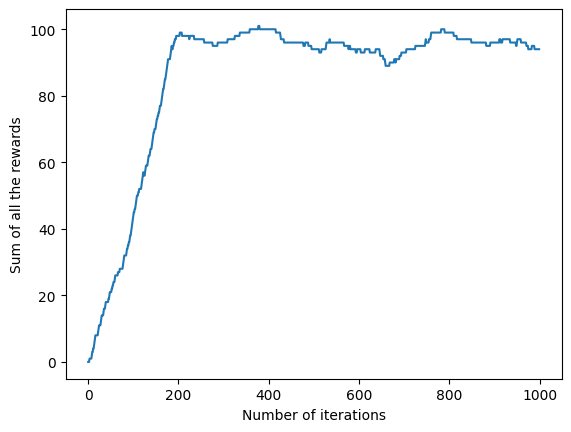

In [17]:
rewards = run(rend=False)

plt.plot(rewards,label="sum of rewards per iteration")
plt.xlabel("Number of iterations")
plt.ylabel("Sum of all the rewards")


In [35]:
#live demo 
run(rend=True, steps=5)

KeyboardInterrupt: 

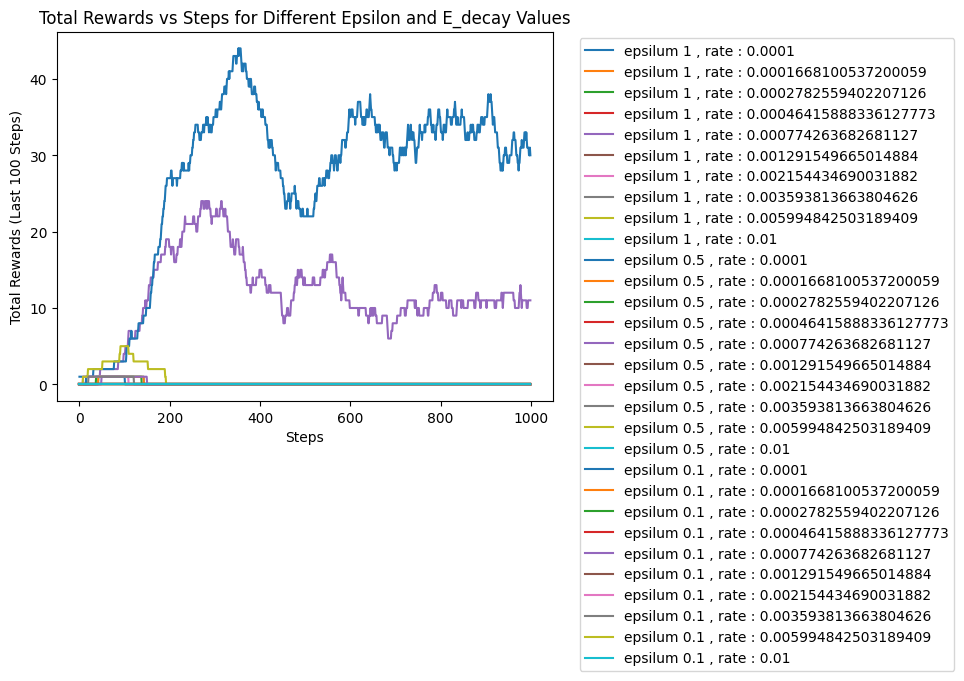

In [33]:
alphas = np.logspace(np.log10(0.0001), np.log10(0.01), num=10)
espilums = [1,0.5,0.1]
e_results = {}
##ver comparativas de cada combinación 

for e in espilums:
    for a_rate in alphas:
        e_results[f"epsilum {e} , rate : {a_rate}"] = run(rend=False,random_map=False)

for epsilon, epsilon_results in e_results.items():
    plt.plot(epsilon_results, label=epsilon)


plt.xlabel('Steps')
plt.ylabel('Total Rewards (Last 100 Steps)')
plt.title('Total Rewards vs Steps for Different Epsilon and E_decay Values')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()